# Michigan Water Quality Analysis - PFAS Surface Water Sampling

## Introduction
This notebook demonstrates a basic data mining project using a dataset on PFAS (Per- and Polyfluoroalkyl Substances) concentrations in surface water samples from Michigan. The goal is to predict the concentration of a specific PFAS compound, ADONA, based on geographical coordinates and the collection year of the samples.



## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Load the Dataset

In [3]:
# Load the dataset
file_path = '/content/PFAS_Surface_Water_Sampling.csv'
df_pfas = pd.read_csv(file_path)

# Display the first few rows
df_pfas.head()

,X,Y,LabSampleId,SiteCode,CocSampleId,SampleType,LabName,LabJobName,Matrix,CollectionDate,...,CAS914637493_53FTCA,CAS914637493_53FTCAFlag,CAS914637493_53FTCAMdl,CAS914637493_53FTCARl,CAS919005144_ADONA,CAS919005144_ADONAFlag,CAS919005144_ADONAMdl,CAS919005144_ADONARl,GlobalID,OBJECTID
0,-83.390600,44.438100,320-58401-1,02-CM-0060,CLARKS MARSH SOUTH,Depth Integrated,TestAmerica Sacramento,320-58401-1,Water,2020/02/03 00:00:00+00,...,NaN,NaN,NaN,NaN,0.16,K,0.16,1.80,{A4C6BA60-845E-4771-8C1D-3F1B0E103595},1
1,-83.373655,44.507457,SL-0100,02-SL-0010,SL-0100,NaN,Vista Analytical,2109148,H20,2021/09/01 00:00:00+00,...,NaN,NaN,NaN,NaN,1.00,K,1.00,4.01,{C428F0AF-BD47-432E-A1E4-CE2C1BBCD8EA},2
2,-83.434334,44.436653,2209070-16,02-AS-0150,AS-0150,NaN,EGLE,2209070,H2O,2022/09/08 00:00:00+00,...,NaN,NaN,NaN,NaN,2.00,K,0.40,2.00,{A0988429-1A8D-4ABB-B435-ED797B3E1F25},3
3,-83.417901,44.511668,2209070-18,02-HC-0030,HC-0030,NaN,EGLE,2209070,H2O,2022/09/08 00:00:00+00,...,NaN,NaN,NaN,NaN,2.00,K,0.40,2.00,{A7C026EF-47AD-4E03-A0F4-B19F35210642},4
4,-84.704890,44.664420,2209069-09,02-AS-0800,AS-0800,NaN,EGLE,2209069,H2O,2022/09/07 00:00:00+00,...,NaN,NaN,NaN,NaN,2.00,K,0.40,2.00,{2FE3521C-B73A-4657-91B2-6C0D9B21B038},5


The dataset contains a variety of columns, including location coordinates (X, Y), sample identification information (LabSampleId, SiteCode, CocSampleId), sample characteristics (SampleType, Matrix, CollectionDate), and a wide range of chemical measurements. With 173 columns, it appears to cover extensive data on water quality, particularly focusing on per- and polyfluoroalkyl substances (PFAS).


For our analysis, let's focus on a specific aspect of water quality. Given the complexity and the wide range of chemicals listed, a thorough analysis of each would be beyond a simple demonstration. Instead, we'll select a few key measurements to model. For instance, we could model the concentration of a specific PFAS compound based on other environmental or chemical factors present in the dataset.


## Data Preprocessing

Let us know the columns of 'df_pfas'

In [4]:
def glimpse(df):
    print(f"Rows: {df.shape[0]}")
    print(f"Columns: {df.shape[1]}")
    for col in df.columns:
        print(f"$ {col} <{df[col].dtype}> {df[col].head().values}")

In [5]:
glimpse(df_pfas)

Rows: 1931
Columns: 173
$ X <float64> [-83.3906     -83.37365456 -83.434334   -83.417901   -84.70489   ]
$ Y <float64> [44.4381     44.50745664 44.436653   44.511668   44.66442   ]
$ LabSampleId <object> ['320-58401-1' 'SL-0100' '2209070-16' '2209070-18' '2209069-09']
$ SiteCode <object> ['02-CM-0060' '02-SL-0010' '02-AS-0150' '02-HC-0030' '02-AS-0800']
$ CocSampleId <object> ['CLARKS MARSH SOUTH' 'SL-0100' 'AS-0150' 'HC-0030' 'AS-0800']
$ SampleType <object> ['Depth Integrated' nan nan nan nan]
$ LabName <object> ['TestAmerica Sacramento' 'Vista Analytical' 'EGLE' 'EGLE' 'EGLE']
$ LabJobName <object> ['320-58401-1' '2109148' '2209070' '2209070' '2209069']
$ Matrix <object> ['Water' 'H20' 'H2O' 'H2O' 'H2O']
$ CollectionDate <object> ['2020/02/03 00:00:00+00' '2021/09/01 00:00:00+00'
 '2022/09/08 00:00:00+00' '2022/09/08 00:00:00+00'
 '2022/09/07 00:00:00+00']
$ AnalysisMethod <object> ['537 (modified)' 'EPA-537M' 'PFAS-8327' 'PFAS-8327' 'PFAS-8327']
$ DilutionFactor <float64> [1. 1. 1.

Given the dataset's focus, let's choose "CAS919005144_ADONA" (concentration of ADONA) as our target variable for predictive modeling. We'll preprocess the data by selecting this target along with a few other relevant features, handling missing values, and then proceed to the next steps.

In [6]:
# Selecting relevant features and handling missing values
features = ['X', 'Y', 'CollectionDate', 'CAS919005144_ADONA']
df_selected = df_pfas[features].copy()

# Simple feature engineering - extracting year from CollectionDate
#df_selected['Year'] = pd.DatetimeIndex(df_selected['CollectionDate']).year
df_selected['CollectionDate'] = pd.to_datetime(df_selected['CollectionDate']).dt.year
df_selected.dropna(inplace=True)

In [7]:
df_selected.head()

,X,Y,CollectionDate,CAS919005144_ADONA
0,-83.390600,44.438100,2020,0.16
1,-83.373655,44.507457,2021,1.00
2,-83.434334,44.436653,2022,2.00
3,-83.417901,44.511668,2022,2.00
4,-84.704890,44.664420,2022,2.00


In [8]:
# Rename the "CollectionDate" column to "CollectionYear"
df_selected = df_selected.rename(columns={"CollectionDate": "CollectionYear"})

## Data Tidying

In [9]:
# Ensure all data types are correct and handle any anomalies
df_selected.info()

# Potential actions might include converting data types, handling outliers, etc. (Not explicitly shown here)

<class 'pandas.core.frame.DataFrame'>
Index: 1132 entries, 0 to 1930
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   X                   1132 non-null   float64
 1   Y                   1132 non-null   float64
 2   CollectionYear      1132 non-null   int32  
 3   CAS919005144_ADONA  1132 non-null   float64
dtypes: float64(3), int32(1)
memory usage: 39.8 KB



## Exploratory Data Analysis (EDA)

The histogram showcases the distribution of ADONA concentrations in the dataset, indicating a range of values with varying frequencies. This visualization helps us understand the variability of ADONA concentration in the samples.

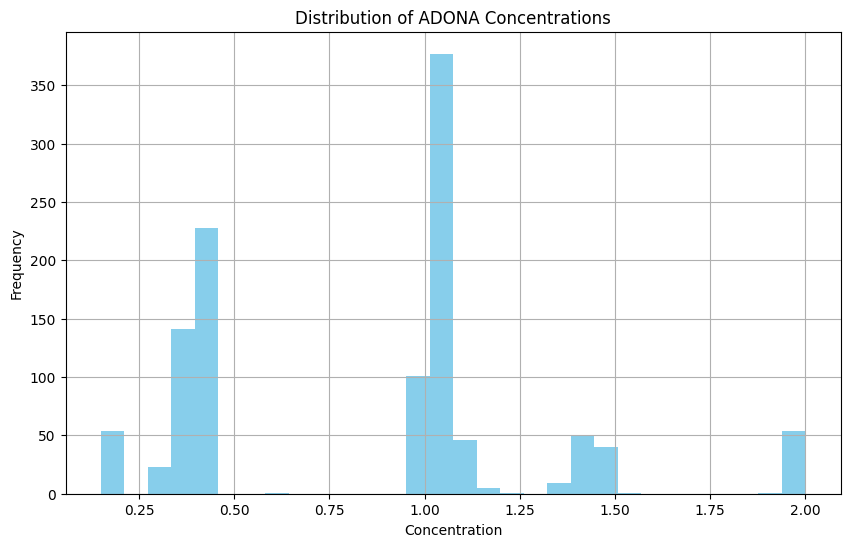

In [10]:
# Histogram of ADONA Concentrations
plt.figure(figsize=(10, 6))
plt.hist(df_selected['CAS919005144_ADONA'], bins=30, color='skyblue')
plt.title('Distribution of ADONA Concentrations')
plt.xlabel('Concentration')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

From the preprocessed dataset, we've retained coordinates (X, Y), the collection year, and the concentration of ADONA. This simplified dataset will serve as the basis for our predictive modeling. Given the nature of the data, let's proceed with a regression model to predict ADONA concentration based on location and collection year. This approach assumes that these features might influence the concentration levels, an assumption that could be explored in more depth with a comprehensive analysis.

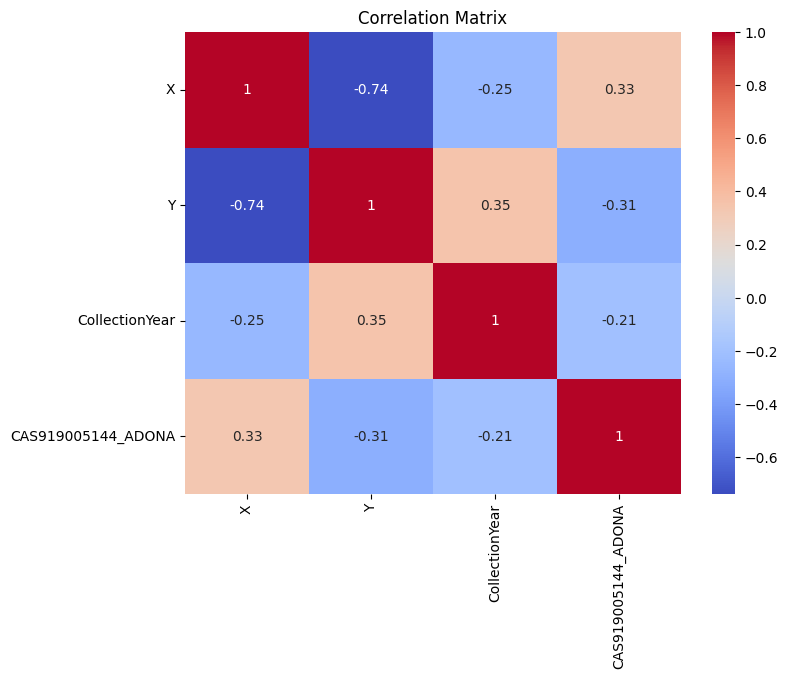

In [11]:
# Correlation matrix
corr_matrix = df_selected.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

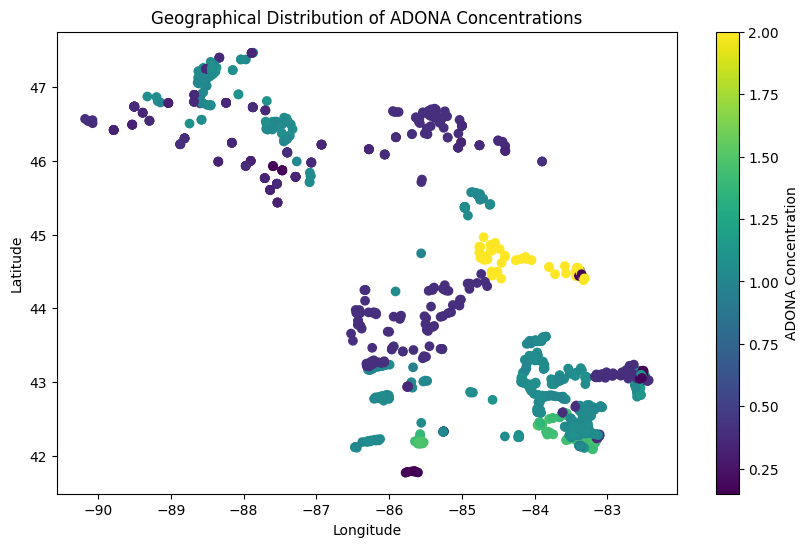

In [12]:
# Scatter plot for geographical distribution of ADONA concentrations
plt.figure(figsize=(10, 6))
plt.scatter(df_selected['X'], df_selected['Y'], c=df_selected['CAS919005144_ADONA'], cmap='viridis')
plt.colorbar(label='ADONA Concentration')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographical Distribution of ADONA Concentrations')
plt.show()

In [13]:
import folium

# Create a map centered around the mean latitude and longitude
center_lat = df_selected['Y'].mean()
center_lon = df_selected['X'].mean()
mymap = folium.Map(location=[center_lat, center_lon], zoom_start=10)

# Add the scatter plot as a layer on the map
for index, row in df_selected.iterrows():
    folium.CircleMarker(location=[row['Y'], row['X']], radius=5,
                        fill=True, fill_color='blue', fill_opacity=0.6,
                        color='black', weight=0.5,
                        popup=f"ADONA Concentration: {row['CAS919005144_ADONA']}").add_to(mymap)

# Display the map
mymap

## Predictive Modeling

Let's split the data into training and test sets, train a linear regression model, and evaluate its performance.

In [15]:
# Splitting the dataset
X = df_selected[['X', 'Y', 'CollectionYear']]
y = df_selected['CAS919005144_ADONA']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.18962790161353263


The Mean Squared Error (MSE) of our linear regression model on the test set is approximately 0.19. This metric indicates the average squared difference between the predicted ADONA concentrations and the actual concentrations in the test set.

## Conclusion
Given the context of environmental data, this MSE value offers a preliminary indication of our model's predictive performance. However, the real-world applicability of this model would require a more in-depth evaluation, including understanding the MSE relative to the range of ADONA concentrations and considering other performance metrics. Additionally, exploring other modeling techniques and a more comprehensive set of features could potentially improve predictions.

This demonstration serves as a foundational approach to predictive modeling with environmental data. In practice, the complexity of water quality data and the factors influencing it necessitate a more nuanced analysis, potentially incorporating spatial analysis due to the geographical data involved, more sophisticated models to capture nonlinear relationships, and a deeper exploration of the underlying processes that influence PFAS concentrations.

